# Assignment 3: Amazon Review Classification System

## Introduction

In this assignment, we were expected to carry out a sentiment classification task using Amazon product reviews. The aim was to predict if a review is positive or negative by using the review's title and content. The negative reviews were the ones with 1 or 2 stars and the positive reviews were the ones with 4 or 5 starts. Reviews with 3 stars were not used to avoid ambiguity, since they are neutral and don't belong in either classes. With this decision, our task became a clean binary classification task.

Different Natural Language Processing (NLP) methods such as Bag-of-Words (BoW) and Word Embeddings were used to extract features. A Naive Bayes classifier that was implemented from scratch was used with the BoW approach. Logistic Regression classifier was used with the features that were gotten from Word Embeddings. Performances of the models were evaluated by using accuracy, precision, recall and F1-score metrics.

## Import Statements

Libraries Used:
* pandas (for data manipulation)
* numpy (for numerical operations)
* matplotlib and seaborn (for visualization)
* scikit-learn (only for train-test split and bonus part)
* wordcloud (for generating a wordcloud for visualization)

In [69]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install wordcloud

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import re

## Data Visualization and Preprocessing

### Understanding Data

The dataset consisted of 3 columns respectively "Title", "Content", "Star". They held values for the title of the review, content of the review and the given star that is an integer ranging from 1 to 5. It contained 72500 rows and each star had equal number of samples.

The dataset contained a few missing values for "Title" and "Content". Since there weren't many of them, we decided to drop the rows with missing values.



In [71]:
# Load the dataset
df = pd.read_csv('amazon_reviews.csv')

In [72]:
# Show the first 5 rows
df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


In [73]:
# Show fundamental information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72500 entries, 0 to 72499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Title    72480 non-null  object 
 1   Content  72493 non-null  object 
 2   Star     72500 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.7+ MB


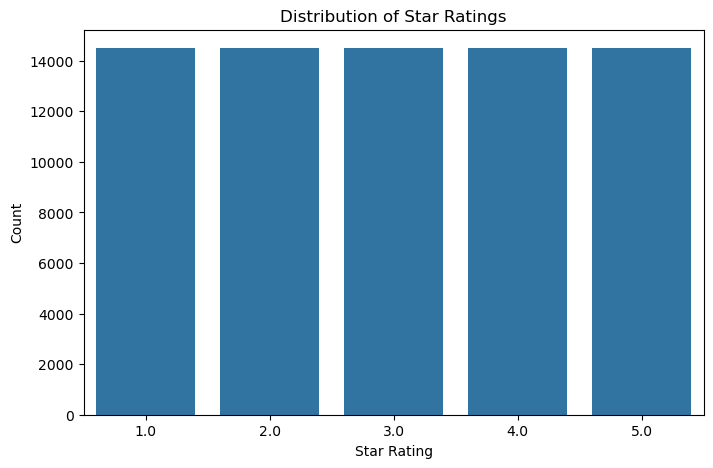

In [74]:
# Visualize the distribution of Star ratings
plt.figure(figsize=(8,5))
sns.countplot(x='Star', data=df)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.show()


In [75]:
# Check for missing values
df.isnull().sum()

Title      20
Content     7
Star        0
dtype: int64

In [76]:
# Drop missing values
df.dropna(inplace=True)

In [77]:
# Check again to confirm
df.isnull().sum()

Title      0
Content    0
Star       0
dtype: int64

### Dropping 3-star Reviews
3-star reviews were discarded instead of treating them as a neutral class because they introduce ambiguity. Neutral classes often make the model confused between positive and negative boundaries. Clear binary labels lead to cleaner decision boundaries.

In [78]:
# Drop 3-star reviews (neutral)
df = df[df['Star'] != 3]

### Mapping Stars to Sentiment Labels

The star values were mapped to two target classes "negative" and "positive" as stated previously.

In [79]:
# Map stars to sentiment labels
def map_sentiment(star):
    if star in [1, 2]:
        return 'negative'
    elif star in [4, 5]:
        return 'positive'

df['Sentiment'] = df['Star'].apply(map_sentiment)


### Combining Title and Content

Rather than processing Title and Content separately, they were merged. The reason is that both provide complementary information about the product review. A title alone can sometimes be misleading without context from the full content.

In [80]:
def merge_title_content(row):
    title = row['Title'] if pd.notnull(row['Title']) else ''
    content = row['Content'] if pd.notnull(row['Content']) else ''
    return title + ' ' + content

# Apply merging
df['text'] = df.apply(merge_title_content, axis=1)

### Preprocessing Merged Text Data

During text preprocessing:

* All text was converted to lowercase.

* Punctuation marks were removed to avoid unnecessary tokens.

* Common stopwords were eliminated.

This preprocessing was crucial to reduce noise and focus the models on meaningful tokens. Removing stopwords, in particular, helped to improve performance by eliminating extremely frequent but semantically weak words.

In [81]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = text.split()
    
    tokens = [word for word in tokens if word not in stopwords]
    
    text = ' '.join(tokens)
    
    return text


Defined stopwords are a specialized version of NLTK's English stopwords. Negation stopwords are specifically kept out of the stopwords list to not lose the meaning in the negative reviews. Some words that specify a degree of something such as "very", "too", "only", "just" are kept out as well since they can be used to give valuable information in the context of reviews.

In [82]:
# Define a specialized stopwords list
stopwords = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself',
    'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those',
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as',
    'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
    'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
    'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
    'own', 'same', 'so', 'than', 's', 't', 'd', 'll', 'm', 'o', 're', 've', 'y',
    'ain', 'ma'
]


In [83]:
# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

In [84]:
# Show 5 examples of merged text data
df['text'].head()

0                           didnt work no change nails
1    worst nail product ever used garbage not waste...
2                  just didnt work nails still brittle
3                               scum didnt improvement
4    okay cuticles helped cuticles didnt much nails...
Name: text, dtype: object

### Visualizing Wordcloud

A wordcloud was used on the preprocessed text data to show the most frequent words in reviews.

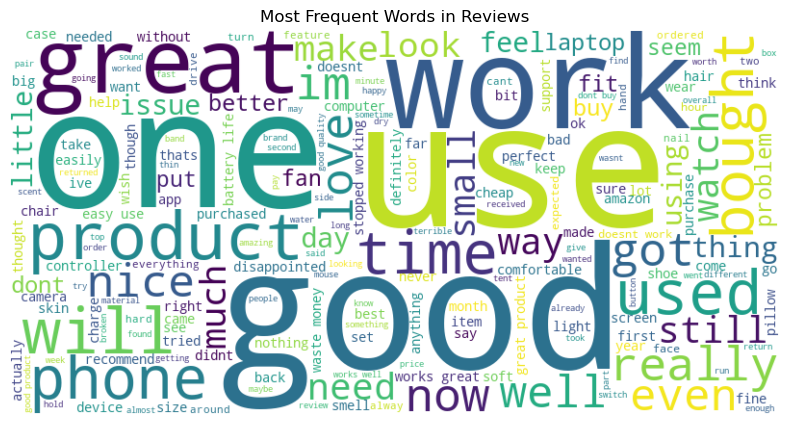

In [85]:
all_text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Reviews')
plt.show()

### Split Data

The dataset was randomly split into 80% training and 20% testing sets, ensuring stratification by sentiment label. This guaranteed that both the training and testing sets maintained the same distribution of positive and negative samples, which is important to prevent bias and ensure fair evaluation.

In [86]:
# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sentiment'])

## Naive Bayes Classifier Implementation


A Naive Bayes Classifier was implemented from scratch with following properties:

* A Bag-of-Words (BoW) dictionary was used for each target class (positive/negative).

* For avoiding zero probabilities with unseen words, laplace smoothing was applied.

* For preventing numerical underflow in the multiplication process, logarithmic probabilities were used.

* 1-star and 5-star reviews were given twice the weight emphasize strong negativity and strong positivity.

In [87]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_word_counts = {}  # class -> {word -> count}
        self.class_counts = {}       # class -> total word count
        self.class_weights = {}      # class -> total weighted count
        self.class_priors = {}       # class -> prior probability
        self.vocab = set()           # unique words

    def train(self, n_grams, stars, labels):
        for n_gram, star, label in zip(n_grams, stars, labels):
            weight = self.get_review_weight(star)
            self.class_weights[label] = self.class_weights.get(label, 0) + weight

            if label not in self.class_word_counts:
                self.class_word_counts[label] = {}
                self.class_counts[label] = 0

            for token in n_gram:
                self.vocab.add(token)
                self.class_word_counts[label][token] = self.class_word_counts[label].get(token, 0) + weight
                self.class_counts[label] += weight

        total_weight = sum(self.class_weights.values())

        for label in self.class_word_counts:
            self.class_priors[label] = np.log(self.class_weights[label] / total_weight)

    def predict(self, n_gram):

        scores = {}

        for label in self.class_word_counts:
            # Start with prior log probability
            score = self.class_priors[label]

            for token in n_gram:
                word_count = self.class_word_counts[label].get(token, 0)
                total_words = self.class_counts[label]
                vocab_size = len(self.vocab)
                # Laplace smoothing
                prob = (word_count + 1) / (total_words + vocab_size)
                score += np.log(prob)

            scores[label] = score

        return max(scores, key=scores.get)

    @staticmethod
    def get_review_weight(star):
        # Give twice the weight for 1-star and 5-star reviews
        if star == 1:
            return 2
        elif star == 2:
            return 1
        elif star == 4:
            return 1
        elif star == 5:
            return 2
        return 0


## Naive Bayes Evaluation with BoW Approach

Features were extracted with three different approaches. Unigram features were extracted in a way that each word represents a token and treated as an individual feature. Bigrams were extracted such that each pair of consecutive words represents a token and Trigrams were extracted such that each triplet of consecutive words represents a token.

By looking at the evaluation results, we can see that using lower-order n-grams (unigram and bigram) provided better results. Bigram provided the best result by a small margin as it allowed the model to capture short-range dependencies without introducing too much sparsity. Even though using higher-order n-grams (trigram) allowed the model to have richer context information, increasing sparsity due to higher n-grams led to signigically decreased performance.

In [88]:
# Manually compute metrics

def compute_metrics(y_true, y_pred):
    tp = sum((yt == 'positive') and (yp == 'positive') for yt, yp in zip(y_true, y_pred))
    tn = sum((yt == 'negative') and (yp == 'negative') for yt, yp in zip(y_true, y_pred))
    fp = sum((yt == 'negative') and (yp == 'positive') for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 'positive') and (yp == 'negative') for yt, yp in zip(y_true, y_pred))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 / (1/recall + 1/precision) if (precision > 0 and recall > 0) else 0

    return accuracy, precision, recall, f1_score

### Unigram

In [89]:
def generate_unigrams(text):
    unigrams = text.split()
    return unigrams

In [90]:
# Train unigrams
train_unigrams = [generate_unigrams(text) for text in train_df['text'].values]

# Test unigrams
test_unigrams = [generate_unigrams(text) for text in test_df['text'].values]

In [91]:
# Create model instance
unigram_model = NaiveBayesClassifier()

# Train the model
unigram_model.train(train_unigrams, train_df["Star"].values, train_df['Sentiment'].values)


In [92]:
# Predict on test set
predictions = [unigram_model.predict(unigram) for unigram in test_unigrams]


In [93]:
# Compute metrics
unigram_accuracy, unigram_precision, unigram_recall, unigram_f1_score = compute_metrics(test_df['Sentiment'].values, predictions)

# Print metrics
print(f"Unigram Model - Accuracy: {unigram_accuracy:.4f}")
print(f"Unigram Model - Precision: {unigram_precision:.4f}")
print(f"Unigram Model - Recall: {unigram_recall:.4f}")
print(f"Unigram Model - F1 Score: {unigram_f1_score:.4f}")


Unigram Model - Accuracy: 0.8715
Unigram Model - Precision: 0.8663
Unigram Model - Recall: 0.8786
Unigram Model - F1 Score: 0.8724


### Bigram

In [94]:
def generate_bigrams(text):
    tokens = text.split()
    bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]
    return bigrams

In [95]:
# Train bigrams
train_bigrams = [generate_bigrams(text) for text in train_df['text'].values]

# Test bigrams
test_bigrams = [generate_bigrams(text) for text in test_df['text'].values]


In [96]:
# Create and train bigram model
bigram_model = NaiveBayesClassifier()
bigram_model.train(train_bigrams, train_df["Star"].values, train_df['Sentiment'].values)


In [97]:
# Predict on bigram test set
bigram_predictions = [bigram_model.predict(bigram) for bigram in test_bigrams]

# Compute metrics for bigram model
bigram_accuracy, bigram_precision, bigram_recall, bigram_f1 = compute_metrics(test_df['Sentiment'].values, bigram_predictions)

# Print metrics
print(f"Bigram Model - Accuracy: {bigram_accuracy:.4f}")
print(f"Bigram Model - Precision: {bigram_precision:.4f}")
print(f"Bigram Model - Recall: {bigram_recall:.4f}")
print(f"Bigram Model - F1 Score: {bigram_f1:.4f}")


Bigram Model - Accuracy: 0.8760
Bigram Model - Precision: 0.8508
Bigram Model - Recall: 0.9119
Bigram Model - F1 Score: 0.8803


### Trigram

In [98]:
def generate_trigrams(text):
    tokens = text.split()
    trigrams = [(tokens[i], tokens[i+1], tokens[i+2]) for i in range(len(tokens)-2)]
    return trigrams


In [99]:
# Train trigrams
train_trigrams = [generate_trigrams(text) for text in train_df['text'].values]

# Test trigrams
test_trigrams = [generate_trigrams(text) for text in test_df['text'].values]


In [100]:
# Create and train trigram model
trigram_model = NaiveBayesClassifier()
trigram_model.train(train_trigrams, train_df["Star"].values, train_df['Sentiment'].values)


In [101]:
# Predict on trigram test set
trigram_predictions = [trigram_model.predict(trigram) for trigram in test_trigrams]

# Compute metrics for trigram model
trigram_accuracy, trigram_precision, trigram_recall, trigram_f1 = compute_metrics(test_df['Sentiment'].values, trigram_predictions)

# Print metrics
print(f"Trigram Model - Accuracy: {trigram_accuracy:.4f}")
print(f"Trigram Model - Precision: {trigram_precision:.4f}")
print(f"Trigram Model - Recall: {trigram_recall:.4f}")
print(f"Trigram Model - F1 Score: {trigram_f1:.4f}")


Trigram Model - Accuracy: 0.6908
Trigram Model - Precision: 0.6239
Trigram Model - Recall: 0.9605
Trigram Model - F1 Score: 0.7565


### Visualization of the results

In [108]:
ngram_results = pd.DataFrame({
    'Model': ['Unigram', 'Bigram', 'Trigram'],
    'Accuracy': [unigram_accuracy, bigram_accuracy, trigram_accuracy],
    'Precision': [unigram_precision, bigram_precision, trigram_precision],
    'Recall': [unigram_recall, bigram_recall, trigram_recall],
    'F1 Score': [unigram_f1_score, bigram_f1, trigram_f1]
}).round(4)

ngram_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Unigram,0.8715,0.8663,0.8786,0.8724
1,Bigram,0.8760,0.8508,0.9119,0.8803
2,Trigram,0.6908,0.6239,0.9605,0.7565


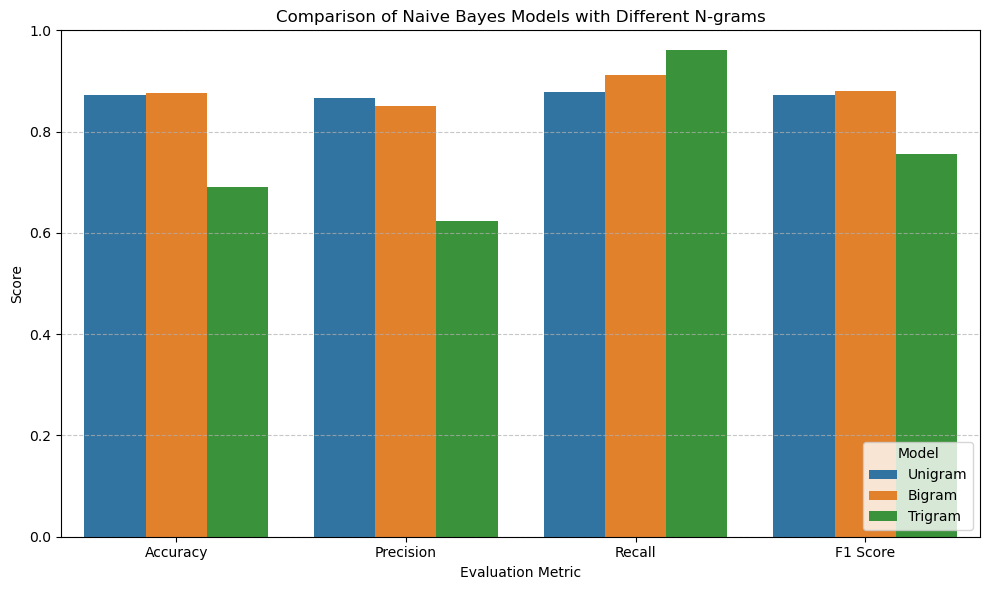

In [117]:
ngram_results_melted = ngram_results.melt(id_vars='Model', var_name='Evaluation Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Evaluation Metric', y='Score', hue='Model', data=ngram_results_melted)

plt.title('Comparison of Naive Bayes Models with Different N-grams')
plt.ylim(0, 1)
plt.legend(title='Model', loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Bonus Part

### Introduction

In this bonus section, we experimented how much the performance of the model changes when "Word Embeddings" with Logistic Regression is used instead of Bag of Words and n-gram approach at the previous part. We used the Word2Vec model to get the word embeddings and document vectors. We chose the Naive Bayes BoW + Bigram from our from the scratch approach for comparison with other models because that was the best performing one. To also evaluate the performance of our from the scratch approach, we used NLTK's Naive Bayes BOW + Bigram. In the end, we compared these three models regarding their evaluation metrics: accuracy, precision, recall and f1-score.

### Import Statements for Bonus Part

In [ ]:
import nltk
from nltk import word_tokenize, bigrams
from nltk.classify import NaiveBayesClassifier
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression


In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kayra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Kayra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kayra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Word2Vec + Logistic Regression

In [ ]:
# Tokenize the sentences
train_tokens = [word_tokenize(text.lower()) for text in train_df['text']]
test_tokens = [word_tokenize(text.lower()) for text in test_df['text']]

# Train the Word2Vec model
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, seed=42)

# Helper function to get document vectors from word embeddings
def document_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Vectorize train and test sets
x_w2v_train = np.array([document_vector(tokens, w2v_model) for tokens in train_tokens])
x_w2v_test = np.array([document_vector(tokens, w2v_model) for tokens in test_tokens])
y_w2v_train = train_df['Sentiment'].values
y_w2v_test = test_df['Sentiment'].values

# Train the Logistic Regression model
regression_model = LogisticRegression(max_iter=1000, random_state=42)
regression_model.fit(x_w2v_train, y_w2v_train)
y_w2v_pred = regression_model.predict(x_w2v_test)

# Evaluate the model

w2v_accuracy, w2v_precision, w2v_recall, w2v_f1 = compute_metrics(y_w2v_test, y_w2v_pred)

print(f"Word2Vec + Logistic Regression - Accuracy: {w2v_accuracy:.4f}")
print(f"Word2Vec + Logistic Regression - Precision: {w2v_precision:.4f}")
print(f"Word2Vec + Logistic Regression - Recall: {w2v_recall:.4f}")
print(f"Word2Vec + Logistic Regression - F1 Score: {w2v_f1:.4f}")


Word2Vec + Logistic Regression - Accuracy: 0.8709
Word2Vec + Logistic Regression - Precision: 0.8808
Word2Vec + Logistic Regression - Recall: 0.8579
Word2Vec + Logistic Regression - F1 Score: 0.8692


### NLTK Naive Bayes with Bigrams

In [ ]:
# Extract bigram features using NLTK
def extract_bigram_features(text):
    tokens = word_tokenize(text.lower())
    bigram_feats = {f'{w1}_{w2}': True for w1, w2 in bigrams(tokens)}
    return bigram_feats

# Get bigram features for training and test sets
train_feats = [(extract_bigram_features(text), label) for text, label in zip(train_df['text'], train_df['Sentiment'])]
test_feats = [(extract_bigram_features(text), label) for text, label in zip(test_df['text'], test_df['Sentiment'])]

# Train and evaluate the NLTK Naive Bayes classifier
classifier_nltk = NaiveBayesClassifier.train(train_feats)

y_nltk_true = [label for (_, label) in test_feats]
y_nltk_pred = [classifier_nltk.classify(feats) for (feats, _) in test_feats]

nltk_accuracy, nltk_precision, nltk_recall, nltk_f1 = compute_metrics(y_nltk_true, y_nltk_pred)
print(f"NLTK Naive Bayes BOW Bigram - Accuracy - {nltk_accuracy:.4f}")
print(f"NLTK Naive Bayes BOW Bigram - Precision - {nltk_precision:.4f}")
print(f"NLTK Naive Bayes BOW Bigram - Recall - {nltk_recall:.4f}")
print(f"NLTK Naive Bayes BOW Bigram - F1 Score - {nltk_f1:.4f}")


NLTK Naive Bayes BOW Bigram Accuracy - 0.8770
NLTK Naive Bayes BOW Bigram Precision - 0.9146
NLTK Naive Bayes BOW Bigram Recall - 0.8317
NLTK Naive Bayes BOW Bigram F1 Score - 0.8712


### Visualization the results

In [112]:
all_results = pd.DataFrame({
    'Model': ['Word2Vec+LR', 'NLTK Bigram', 'Custom Bigram'],
    'Accuracy': [w2v_accuracy, nltk_accuracy, bigram_accuracy],
    'Precision': [w2v_precision, nltk_precision, bigram_precision],
    'Recall': [w2v_recall, nltk_recall, bigram_recall],
    'F1 Score': [w2v_f1, nltk_f1, bigram_f1]
}).round(4)

all_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Word2Vec+LR,0.8709,0.8808,0.8579,0.8692
1,NLTK Bigram,0.8770,0.9146,0.8317,0.8712
2,Custom Bigram,0.8760,0.8508,0.9119,0.8803


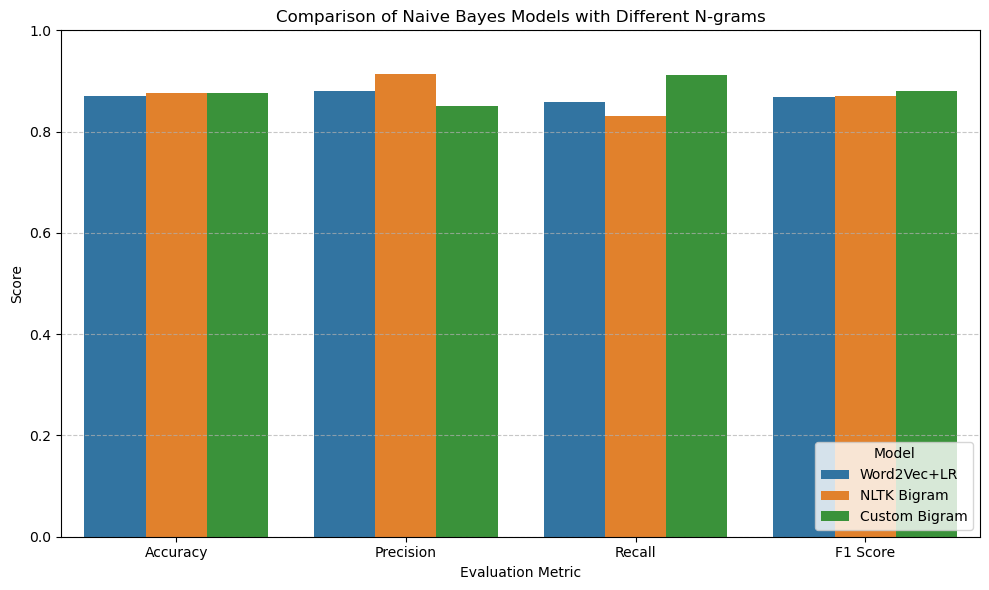

In [116]:
all_results_melted = all_results.melt(id_vars='Model', var_name='Evaluation Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Evaluation Metric', y='Score', hue='Model', data=all_results_melted)

plt.title('Comparison of Naive Bayes Models with Different N-grams')
plt.ylim(0, 1)
plt.legend(title='Model', loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Result Evaluation

First of all, we can see that all of these models performed very good and similarly to each other with their accuracies being around ~0.87. This means that we've implemented a great BoW + Naive Bayes model from the scratch although they have some differences when we look at the other evaluation metrics.

When we further investigate the results, we can see that NLTK-based bigram model achieved the highest accuracy and precision, while our custom from the scratch model shows the best F1-score, indicating a more balanced performance. It also gets the highest recall, meaning it is more effective at identifying positive cases in the dataset.

The Word2Vec + Logistic Regression model achieved the most balanced and solid results across all metrics, especially in precision. It may be because of the improved semantic understanding introduced by word embeddings. It also is slightly worse in recall scores than bigram based models. The reason for that can be due to averaging of word vectors, which can decrease the contextual weight of some word pairings captured better in bigram models.

In conclusion, while word embeddings usually offer more modern and generalizable alternative to n-gram based features, in our task, they both performed equally good as it can be seen from the evaluation metrics. The reason why the n-gram based features still performed very solid is that they are better at capturing local word dependencies, such as "very good" and "not bad". In the reviews, some of these pairings are very informative and it makes the reviews easier to label them as "positive" or "negative".